In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error

sns.set_palette('rocket')
plt.rcParams['image.cmap'] = 'rocket'
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)

In [33]:
df = pd.read_csv('datasets/cleaned/merged_fx_dataset.csv')

In [34]:
# Convert 'Date' to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date').set_index('Date')

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4217 entries, 2008-01-02 to 2024-12-31
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Buying                    4217 non-null   float64
 1   Selling                   4217 non-null   float64
 2   MidRate                   4217 non-null   float64
 3   MPR                       4217 non-null   float64
 4   GhInflationRate           4217 non-null   float64
 5   BrentOil                  4217 non-null   float64
 6   Cocoa                     4217 non-null   float64
 7   Gold                      4217 non-null   float64
 8   GhInterestRate            4217 non-null   float64
 9   NetForeignAssets          4217 non-null   float64
 10  NIR                       4217 non-null   float64
 11  Imports                   4217 non-null   float64
 12  Exports                   4217 non-null   float64
 13  GhGDP                     4217 non-null   flo

In [35]:
TARGET = 'Buying'
DROP_COLUMNS = [TARGET, 'Selling', 'MidRate']

In [36]:
# Initialize a list of all raw features we want to keep
FEATURES = df.drop(columns=DROP_COLUMNS).columns.tolist()

In [37]:
FEATURES

['MPR',
 'GhInflationRate',
 'BrentOil',
 'Cocoa',
 'Gold',
 'GhInterestRate',
 'NetForeignAssets',
 'NIR',
 'Imports',
 'Exports',
 'GhGDP',
 'USGDP',
 'USInflationRate',
 'USInterestRate']

In [38]:
LAGS  = [5, 20, 60] # Lags for 1 week, 1 month, 1 quarter

##### Lagged Features for Target (Short- & Medium-Term Momentum)

In [39]:
for lag in LAGS:
    column_name = f'{TARGET}Lag{lag}d'
    df[column_name] = df[TARGET].shift(lag)
    FEATURES.append(column_name)

##### Economic Differentials (Fundamental Drivers)

In [40]:
# Interest Rate Parity (IRP)
df['InterestRateDifferential'] = df['GhInterestRate'] - df['USInterestRate']
FEATURES.append('InterestRateDifferential')

# Purchasing Power Parity (PPP)
df['InflationDifferential'] = df['GhInflationRate'] - df['USInflationRate']
FEATURES.append('InflationDifferential')

# Trade Balance (Currency Flow)
df['TradeBalance'] = df['Exports'] - df['Imports']
FEATURES.append('TradeBalance')

In [41]:
# C. Time-based Features (Cyclicality)
df['DayOfWeek'] = df.index.dayofweek
df['DayOfYear'] = df.index.dayofyear
# Binary feature for structural month-end flows
df['IsMonthEnd'] = df.index.is_month_end.astype(int)
FEATURES.extend(['DayOfWeek', 'DayOfYear', 'IsMonthEnd'])

In [42]:
# D. Growth Rates for Low-Frequency Data (Economic Momentum)
# Use 65-day shift as a proxy for Quarter-over-Quarter (QoQ) Growth
QUARTERLY_SHIFT = 65
df['GhGDPQoQGrowth'] = (
    df['GhGDP'] / df['GhGDP'].shift(QUARTERLY_SHIFT) - 1) * 100
df['USGDPQoQGrowth'] = (
    df['USGDP'] / df['USGDP'].shift(QUARTERLY_SHIFT) - 1) * 100
FEATURES.extend(['GhGDPQoQGrowth', 'USGDPQoQGrowth'])

##### Final Data Preparation and Split 

In [43]:
[TARGET] + FEATURES

['Buying',
 'MPR',
 'GhInflationRate',
 'BrentOil',
 'Cocoa',
 'Gold',
 'GhInterestRate',
 'NetForeignAssets',
 'NIR',
 'Imports',
 'Exports',
 'GhGDP',
 'USGDP',
 'USInflationRate',
 'USInterestRate',
 'BuyingLag5d',
 'BuyingLag20d',
 'BuyingLag60d',
 'InterestRateDifferential',
 'InflationDifferential',
 'TradeBalance',
 'DayOfWeek',
 'DayOfYear',
 'IsMonthEnd',
 'GhGDPQoQGrowth',
 'USGDPQoQGrowth']

In [44]:
# Drop initial rows with NaN values created by lagging/growth rate calculations
df_clean = df.dropna(subset=[TARGET] + FEATURES)

In [45]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4152 entries, 2008-04-08 to 2024-12-31
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Buying                    4152 non-null   float64
 1   Selling                   4152 non-null   float64
 2   MidRate                   4152 non-null   float64
 3   MPR                       4152 non-null   float64
 4   GhInflationRate           4152 non-null   float64
 5   BrentOil                  4152 non-null   float64
 6   Cocoa                     4152 non-null   float64
 7   Gold                      4152 non-null   float64
 8   GhInterestRate            4152 non-null   float64
 9   NetForeignAssets          4152 non-null   float64
 10  NIR                       4152 non-null   float64
 11  Imports                   4152 non-null   float64
 12  Exports                   4152 non-null   float64
 13  GhGDP                     4152 non-null   flo

In [47]:
df_clean.drop(columns=['Selling', 'MidRate', 'MPR'], inplace=True)

/var/folders/pq/lv4328kx4fjg40sltdfjtrcm0000gn/T/ipykernel_18199/1357856316.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.drop(columns=['Selling', 'MidRate', 'MPR'], inplace=True)


In [49]:
# Finalize feature list by intersecting with available columns
FINAL_FEATURES = [f for f in FEATURES if f in df_clean.columns]

In [50]:
FINAL_FEATURES

['GhInflationRate',
 'BrentOil',
 'Cocoa',
 'Gold',
 'GhInterestRate',
 'NetForeignAssets',
 'NIR',
 'Imports',
 'Exports',
 'GhGDP',
 'USGDP',
 'USInflationRate',
 'USInterestRate',
 'BuyingLag5d',
 'BuyingLag20d',
 'BuyingLag60d',
 'InterestRateDifferential',
 'InflationDifferential',
 'TradeBalance',
 'DayOfWeek',
 'DayOfYear',
 'IsMonthEnd',
 'GhGDPQoQGrowth',
 'USGDPQoQGrowth']

In [52]:
x = df_clean[FINAL_FEATURES]
y = df_clean[TARGET]

print(
    f"Data ready. Total features: {len(FINAL_FEATURES)}, Cleaned data shape: {x.shape}")

Data ready. Total features: 24, Cleaned data shape: (4152, 24)


##### Model Setup and Hyperparameter Tuning (Grid Search)

In [53]:
# Time-Series Split (Walk-Forward Validation)
# The training set grows with each fold, respecting the temporal order.
time_series_split = TimeSeriesSplit(n_splits=5)

In [54]:
# Gradient Boosting Regressor baseline model
gbr = GradientBoostingRegressor(random_state=42)

In [55]:
# Hyperparameter Grid: Focused search based on best practices
parameter_grid = {
    'n_estimators': [100, 200],     # Number of trees (Complexity)
    'learning_rate': [0.05, 0.1],   # Step size shrinkage (Regularization)
    'max_depth': [3, 5],            # Depth of individual trees (Complexity)
    'subsample': [0.7, 0.9]         # Stochasticity (Regularization)
}

In [56]:
# Grid Search setup (optimizing for the robust Mean Squared Error)
grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=parameter_grid,
    scoring='neg_mean_squared_error',
    cv=time_series_split,  # Use TimeSeriesSplit
    verbose=2,
    n_jobs=-1
)

In [57]:
print("\nStarting Grid Search with TimeSeriesSplit (Walk-Forward Validation)...")
grid_search.fit(x, y)


Starting Grid Search with TimeSeriesSplit (Walk-Forward Validation)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.4s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.8s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.8s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.9s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.9; total time=   1.1s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.7; total time=   1.2s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.7; total time=   1.3s
[CV] END learning_rat

,estimator,GradientBoost...ndom_state=42)
,param_grid,"{'learning_rate': [0.05, 0.1], 'max_depth': [3, 5], 'n_estimators': [100, 200], 'subsample': [0.7, 0.9]}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'squared_error'


In [59]:
# Retrieve the best model found
best_gbr = grid_search.best_estimator_

In [60]:
# Predict using the best model on the training data (for evaluation metrics)
y_predictions = best_gbr.predict(x)

In [62]:
# Calculate final metrics
mae = mean_absolute_error(y, y_predictions)
mse = mean_squared_error(y, y_predictions)
rmse = root_mean_squared_error(y, y_predictions)
np_rmse = np.sqrt(mse)
r2 = r2_score(y, y_predictions)

In [63]:
evaluation_results = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'np.sqrt(MSE)', 'R2'],
    'Value': [mae, mse, rmse, np_rmse, r2]
})

evaluation_results

,Metric,Value
0,MAE,0.021624
1,MSE,0.003176
2,RMSE,0.056359
3,np.sqrt(MSE),0.056359
4,R2,0.999753


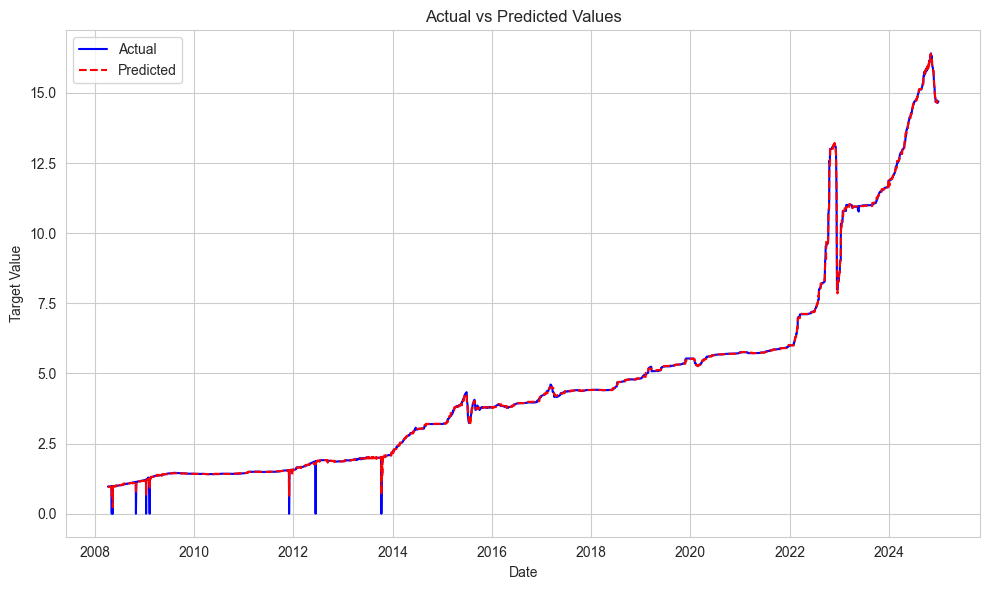

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(y.index, y, label='Actual', color='b')
plt.plot(y.index, y_predictions, label='Predicted', color='r', linestyle='--')
plt.xlabel('Date' if hasattr(y.index, 'dtype') and 'datetime' in str(y.index.dtype) else 'Index')
plt.ylabel('Target Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.tight_layout()
plt.savefig('plots/gb/actual_vs_predicted.png')
plt.show()


#### LSTM

In [66]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Deep Learning specific imports (Requires TensorFlow/Keras)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2025-10-17 20:53:51.227315: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [69]:
TIMESTEPS = 5

In [67]:
x_data = df_clean[FINAL_FEATURES].values
y_data = df_clean[TARGET].values.reshape(-1, 1)  # Reshape for scaling

print(f"Total features for LSTM: {len(FINAL_FEATURES)}")
# --- 2. Scaling (MANDATORY for LSTM) ---
scaler_x = MinMaxScaler(feature_range=(0, 1))
x_scaled = scaler_x.fit_transform(x_data)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y_data)

Total features for LSTM: 24


In [68]:
def create_sequences(x, y, timesteps):
    """
    Transforms 2D arrays into 3D sequences for LSTM training.
    [samples, timesteps, features]
    """
    x_seq, y_seq = [], []
    for i in range(len(x) - timesteps):
        # Create a sequence of input features of length 'timesteps'
        x_seq.append(x[i:i + timesteps, :])
        # The target is the value immediately following the sequence
        y_seq.append(y[i + timesteps, 0])
    return np.array(x_seq), np.array(y_seq)

In [70]:
x_seq, y_seq = create_sequences(x_scaled, y_scaled, TIMESTEPS)
print(f"LSTM Input Shape (Samples, Timesteps, Features): {x_seq.shape}")

LSTM Input Shape (Samples, Timesteps, Features): (4147, 5, 24)


In [71]:
SPLIT_DATE = '2023-01-01'

In [73]:
split_index = df_clean.index.get_indexer([SPLIT_DATE], method='ffill')[0]

In [74]:
split_index

3655

In [79]:
train_size = split_index - TIMESTEPS
train_size

3650

In [80]:
x_train, x_test = x_seq[:train_size], x_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

In [75]:
model = Sequential([
    # First LSTM layer with high units and return_sequences=True to feed to the next LSTM layer
    LSTM(units=100, return_sequences=True,
         input_shape=(TIMESTEPS, x_seq.shape[2])),
    Dropout(0.3),  # Regularization to prevent overfitting

    # Second LSTM layer
    LSTM(units=100, return_sequences=False),
    Dropout(0.3),

    # Output layer (Single unit for regression prediction)
    Dense(units=1)
])

/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [76]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 100)         │        50,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,501 (509.77 KB)

 Trainable params: 130,501 (509.77 KB)

 Non-trainable params: 0 (0.00 B)

None


In [77]:
early_stop = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

In [81]:
print("\nStarting LSTM Training...")
history = model.fit(
    x_train, y_train,
    epochs=50,  # Start with a reasonable number of epochs
    batch_size=32,
    validation_split=0.1,  # Use 10% of training data for validation loss monitoring
    callbacks=[early_stop],
    verbose=1
)


Starting LSTM Training...
Epoch 1/50


103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0025 - val_loss: 0.0167
Epoch 2/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.9135e-04 - val_loss: 0.0136
Epoch 3/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.6387e-04 - val_loss: 0.0123
Epoch 4/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.4470e-04 - val_loss: 0.0119
Epoch 5/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.3177e-04 - val_loss: 0.0119
Epoch 6/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.7817e-04 - val_loss: 0.0132
Epoch 7/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.2723e-04 - val_loss: 0.0114
Epoch 8/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.1947e-04 - val_loss: 0.0144
Epoch 9/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.7759e-04 - val_loss: 0.0129
Epoch 10/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8604e-04 - val_loss: 0.0146
Epoch 11/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.3985e-04 - val_loss: 0.0154
Epoch 12/50
103/103 ━━

In [82]:
y_pred_scaled = model.predict(x_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [83]:
# Inverse transform predictions and actuals to original scale for metric calculation
y_test_unscaled = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred_unscaled = scaler_y.inverse_transform(y_pred_scaled)

# Calculate final metrics
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_unscaled, y_pred_unscaled)

print("\n" + "="*50)
print("--- Final Model Evaluation (LSTM) on Test Set ---")
print(f"TimeSteps (Lookback Window): {TIMESTEPS}")
print("-" * 50)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(
    f"R-squared Target Achievement: {'ACHIEVED' if r2 >= 0.70 else 'NOT ACHIEVED'}")
print("="*50)


--- Final Model Evaluation (LSTM) on Test Set ---
TimeSteps (Lookback Window): 5
--------------------------------------------------
Mean Absolute Error (MAE): 4.2019
Mean Squared Error (MSE): 20.0141
Root Mean Squared Error (RMSE): 4.4737
R-squared (R²): -4.5177
R-squared Target Achievement: NOT ACHIEVED


In [87]:
# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Deep Learning specific imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Keras Tuner
import keras_tuner as kt
from keras_tuner import RandomSearch  # Use RandomSearch for efficiency

# --- Global Configurations ---
TARGET = 'Buying'
TIMESTEPS = 5
SPLIT_DATE = '2023-01-01'  # Split data before this date for training, after for test

# --- 1. Data Loading and Preparation (Reused) ---

df = pd.read_csv("datasets/cleaned/merged_fx_dataset.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date').set_index('Date')

# Feature Engineering
DROP_COLS = [TARGET, 'Selling', 'MidRate']
FEATURES = df.drop(columns=DROP_COLS).columns.tolist()

df['InterestRate_Diff'] = df['GhInterestRate'] - df['USInterestRate']
df['Inflation_Diff'] = df['GhInflationRate'] - df['USInflationRate']
df['Trade_Balance'] = df['Exports'] - df['Imports']
df['DayOfWeek'] = df.index.dayofweek
df['DayOfYear'] = df.index.dayofyear
df['Is_Month_End'] = df.index.is_month_end.astype(int)
QUARTERLY_SHIFT = 65
df['GhGDP_QoQ_Growth'] = (
    df['GhGDP'] / df['GhGDP'].shift(QUARTERLY_SHIFT) - 1) * 100
df['USGDP_QoQ_Growth'] = (
    df['USGDP'] / df['USGDP'].shift(QUARTERLY_SHIFT) - 1) * 100

FEATURES.extend(
    [col for col in df.columns if col not in df.columns[:len(df.columns) - 8]])

# Finalize data
df_clean = df.dropna()
FINAL_FEATURES = [f for f in FEATURES if f in df_clean.columns]
X_data = df_clean[FINAL_FEATURES].values
y_data = df_clean[TARGET].values.reshape(-1, 1)

# --- 2. Scaling and Sequence Creation ---
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X_data)
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y_data)


def create_sequences(X, y, timesteps):
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps):
        X_seq.append(X[i:i + timesteps, :])
        y_seq.append(y[i + timesteps, 0])
    return np.array(X_seq), np.array(y_seq)


X_seq, y_seq = create_sequences(X_scaled, y_scaled, TIMESTEPS)
N_FEATURES = X_seq.shape[2]

# --- 3. Time-Based Train/Test Split ---
# split_idx = df_clean.index.get_loc(SPLIT_DATE, method='ffill')[0]
split_idx = df_clean.index.get_indexer([SPLIT_DATE], method='ffill')[0]
train_size = split_idx - TIMESTEPS

X_train_full, X_test = X_seq[:train_size], X_seq[train_size:]
y_train_full, y_test = y_seq[:train_size], y_seq[train_size:]


# --- 4. Keras Tuner Model Definition Function ---
def build_model(hp):
    """Defines the LSTM architecture with searchable hyperparameters."""
    model = Sequential()

    # Define the number of LSTM layers (1 or 2)
    num_lstm_layers = hp.Int(
        'num_lstm_layers', min_value=1, max_value=2, step=1)

    for i in range(num_lstm_layers):
        model.add(LSTM(
            units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32),
            # Only True if not the last LSTM layer
            return_sequences=(i < num_lstm_layers - 1),
            # Input shape only needed for the first layer
            input_shape=(TIMESTEPS, N_FEATURES) if i == 0 else None
        ))
        # Add a searchable dropout rate
        model.add(
            Dropout(hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(units=1))

    # Compile the model with a searchable learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mse')
    return model

# --- 5. Hyperparameter Search (Random Search with TimeSeriesSplit) ---


# Define TimeSeriesSplit for Walk-Forward Validation
tscv = TimeSeriesSplit(n_splits=3)  # Use fewer splits for quicker tuning

# Define the Tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',  # Optimize for validation loss
    max_trials=10,        # Number of different models to test
    executions_per_trial=1,  # How many times to fit each model configuration
    directory='keras_tuner_fx',
    project_name='lstm_fx_tuning',
    overwrite=True
)

print("\nStarting Keras Tuner Random Search with TimeSeriesSplit...")

# Custom tuning loop to enforce TimeSeriesSplit
best_val_loss = float('inf')
best_hps = None

for fold, (train_index, val_index) in enumerate(tscv.split(X_train_full)):
    print(f"\n--- Fitting Fold {fold+1} ---")

    X_train_fold, X_val_fold = X_train_full[train_index], X_train_full[val_index]
    y_train_fold, y_val_fold = y_train_full[train_index], y_train_full[val_index]

    # Search within the current fold's split
    tuner.search(
        X_train_fold, y_train_fold,
        epochs=15,  # Use short epochs for quick initial search
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=5)]
    )

# Get the optimal hyperparameters found across all folds
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"\nOptimal Hyperparameters Found: {best_hps.values}")

# --- 6. Final Model Training and Evaluation ---

# Build the final model with the optimal hyperparameters
final_model = tuner.hypermodel.build(best_hps)

# Train the final model on the full training set (X_train_full)
print("\nTraining final model on full training set...")
history = final_model.fit(
    X_train_full, y_train_full,
    epochs=50,  # Use more epochs for the final run
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=0
)

# Predict on the hold-out test set
y_pred_scaled = final_model.predict(X_test)

# Inverse transform predictions and actuals to original scale
y_test_unscaled = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred_unscaled = scaler_y.inverse_transform(y_pred_scaled)

# Calculate final metrics
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_unscaled, y_pred_unscaled)

print("\n" + "="*50)
print("--- Final Model Evaluation (LSTM - Keras Tuner) on Test Set ---")
print(f"Optimal Learning Rate: {best_hps.get('learning_rate')}")
print(f"Optimal Units (Layer 0): {best_hps.get('units_0')}")
print("-" * 50)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(
    f"R-squared Target Achievement: {'ACHIEVED' if r2 >= 0.70 else 'NOT ACHIEVED'}")
print("="*50)

Trial 10 Complete [00h 00m 08s]
val_loss: 0.005776851437985897

Best val_loss So Far: 0.0028787849005311728
Total elapsed time: 00h 00m 59s

--- Fitting Fold 2 ---

--- Fitting Fold 3 ---

Optimal Hyperparameters Found: {'num_lstm_layers': 1, 'units_0': 64, 'dropout_0': 0.2, 'learning_rate': 0.0001}

Training final model on full training set...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

--- Final Model Evaluation (LSTM - Keras Tuner) on Test Set ---
Optimal Learning Rate: 0.0001
Optimal Units (Layer 0): 64
--------------------------------------------------
Mean Absolute Error (MAE): 2.0054
Mean Squared Error (MSE): 7.0241
Root Mean Squared Error (RMSE): 2.6503
R-squared (R²): -0.9365
R-squared Target Achievement: NOT ACHIEVED
